In [1]:
import os, sys
sys.path.insert(0, os.environ['PROJECT_PATH'])

In [2]:
from __future__ import print_function
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans, MiniBatchKMeans

from config.resources import path_to

In [3]:
import matplotlib, matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [4]:
dset_name = 'freeman'
jbv_df = pd.read_csv(path_to[dset_name + '_meta'])
jbv_df.shape
# print(jbv_df.loc[21542])

(25550, 68)

In [5]:
# drop abstracts with nan and placeholder values
jbv_df.dropna(inplace=True, subset=[ 'AB' ])
jbv_df = jbv_df[ jbv_df.AB != 'AB']

# sort resulting dataframe by year
jbv_df.sort_values('PY', inplace=True)
jbv_df.shape

(15024, 68)

Number of unique author keywords in corpus: 0


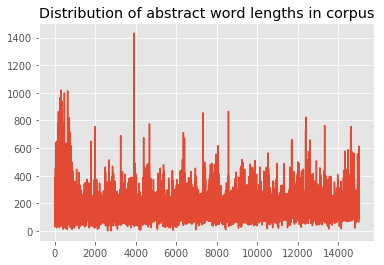

In [6]:
jbv_df['abstract_len'] = jbv_df['AB'].dropna().apply(lambda a: len(a.split()))
jbv_df['keyword_ls'] = jbv_df['DE'].dropna().apply(lambda a: a.split(';'))

plt.plot(jbv_df['abstract_len'].tolist())
plt.title('Distribution of abstract word lengths in corpus')

keyword_set = { k for _, row in jbv_df.dropna().iterrows() for k in row['keyword_ls'] }

print('Number of unique author keywords in corpus:', len(keyword_set))

In [7]:
citation_ls = jbv_df.CR.dropna().tolist()
len(citation_ls), jbv_df.shape[0]

(14747, 15024)

In [8]:
import re

pattern = re.compile('freeman r\.?\s*e[\.;,\s]', re.IGNORECASE)
jbv_df['cites_freeman'] = jbv_df.CR.apply(lambda c: not pd.isnull(c) and pattern.search(c) is not None)

In [10]:
def is_social_topic(row, pattern):
    query = row[ ['TI', 'AB', 'DE', 'ID'] ]
    matches = [ not pd.isnull(el) and pattern.search(el) is not None \
                for el in query]
    return any(matches)

pattern = re.compile('social', re.IGNORECASE)
jbv_df['is_social_topic'] = jbv_df.apply(lambda r: is_social_topic(r, pattern), axis=1)
# pattern.search('socielogiy,') is not None

In [11]:
jbv_df[ jbv_df['cites_freeman'] ][ ['CR', 'cites_freeman'] ].shape[0]

79

In [12]:
x = jbv_df[ jbv_df['is_social_topic'] ][ ['TI', 'DE', 'AB'] ]
x.shape

(4195, 3)

In [13]:
nb_features = 200
custom_stop_words = set(['elsevier', 'rights', 'reserved']).union(ENGLISH_STOP_WORDS)
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=nb_features, stop_words=custom_stop_words)

doc_mat = vectorizer.fit_transform(jbv_df.AB)

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

pairwise_doc_similarity = cosine_similarity(doc_mat)
pca = PCA(n_components=2, random_state=1)
doc_similarity_pts = pca.fit_transform(pairwise_doc_similarity)
doc_similarity_pts.shape

(15024, 2)

In [15]:
xs, ys = doc_similarity_pts[:, 0], doc_similarity_pts[:, 1]

doc_similarity_df = pd.DataFrame(dict(x=xs, y=ys, title=jbv_df.TI, is_social=jbv_df.is_social_topic))

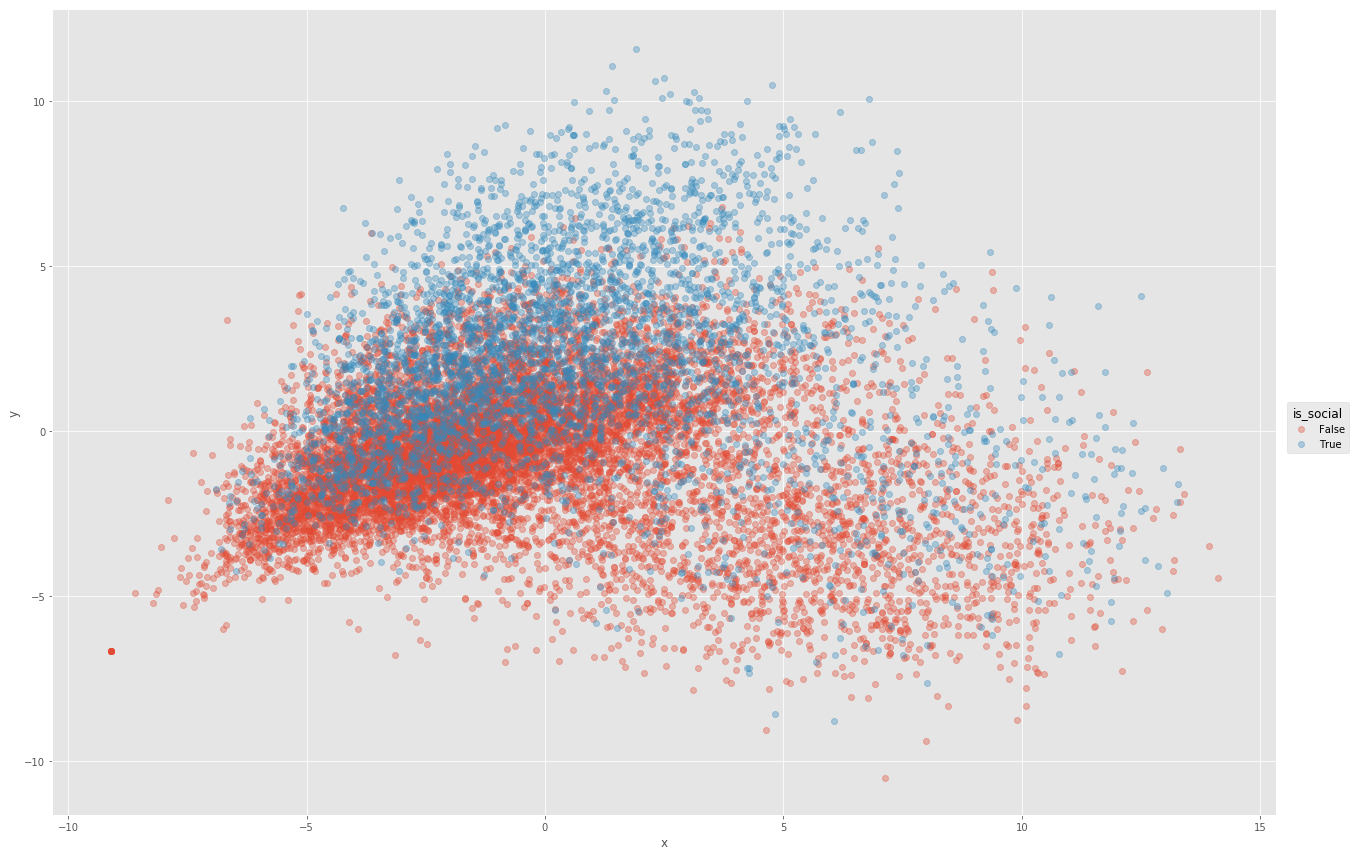

In [17]:
import seaborn as sns

sns.lmplot(x='x', y='y', data=doc_similarity_df, hue='is_social',fit_reg=False, 
           size=12, aspect=1.5, scatter_kws={ 'alpha': 0.35 })
# plt.plot(xs, ys, linestyle='', marker='o')

### Topic modeling society related entrepreneurial papers

In [19]:
is_social_corpus = jbv_df[ jbv_df.is_social_topic ]
society_related_abstracts_corpus = is_social_corpus.AB.tolist()
# tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=nb_features, stop_words=custom_stop_words)
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=nb_features, stop_words=custom_stop_words)

tfidf_doc_mat = tfidf_vectorizer.fit_transform(society_related_abstracts_corpus)
tfidf_feat_names = tfidf_vectorizer.get_feature_names()

In [26]:
from textacy.tm import TopicModel

nb_topics=15
nmf = TopicModel(model='nmf', n_topics=nb_topics)
doc_term_mat = nmf.fit(tfidf_doc_mat)
doc_topic_mat = nmf.get_doc_topic_matrix(tfidf_doc_mat)
doc_topic_mat.shape

(4195, 15)

In [27]:
import numpy as np
topic_wts = np.nansum(doc_topic_mat, axis=0)
sorted_topic_wt_ids = np.argsort(topic_wts)
for idx in sorted_topic_wt_ids:
    print('Topic: {}, Wt: {}'.format(idx+1, topic_wts[idx]))

Topic: 12, Wt: 108.377209855
Topic: 4, Wt: 135.74606662
Topic: 14, Wt: 167.429959856
Topic: 9, Wt: 177.060599896
Topic: 10, Wt: 179.107715625
Topic: 5, Wt: 179.861269397
Topic: 2, Wt: 183.260941488
Topic: 13, Wt: 202.567539007
Topic: 15, Wt: 281.522168174
Topic: 7, Wt: 380.476732501
Topic: 1, Wt: 399.516472276
Topic: 11, Wt: 399.769158938
Topic: 3, Wt: 418.250025942
Topic: 8, Wt: 453.480552454
Topic: 6, Wt: 528.573587971


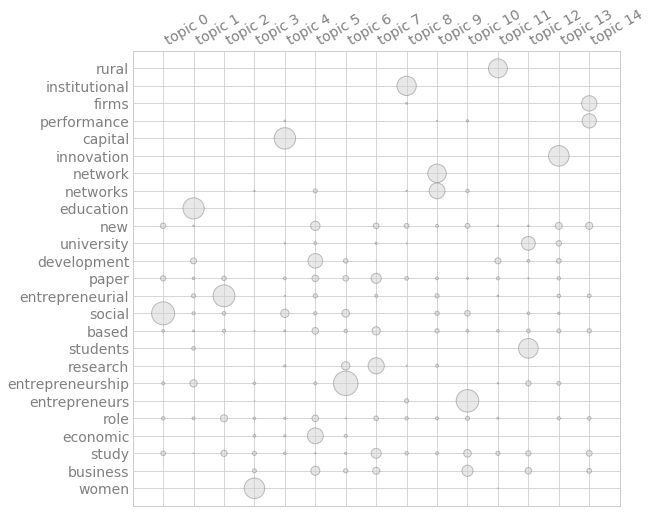

In [28]:
nmf.termite_plot(tfidf_doc_mat, tfidf_feat_names, topics=-1, n_terms=25, sort_terms_by='seriation')

In [29]:
for topic_idx, topic_data in nmf.top_topic_terms(tfidf_feat_names, topics=range(nb_topics), weights = True):
    topic_terms = [ topic_term + '*' + str(round(topic_prob, 2)) for topic_term, topic_prob in topic_data]
    print('topic', topic_idx + 1, ':', ' | '.join(topic_terms), '\n')
#     print('topic', topic_idx + 1, ':', ' | '.join(topic_terms), file=f)

topic 1 : social*5.62 | enterprises*0.87 | enterprise*0.73 | organizations*0.68 | problems*0.58 | entrepreneur*0.51 | article*0.5 | value*0.45 | concept*0.44 | community*0.41 

topic 2 : education*4.75 | higher*0.89 | universities*0.59 | entrepreneurship*0.55 | learning*0.52 | training*0.48 | development*0.37 | skills*0.37 | people*0.18 | society*0.18 

topic 3 : entrepreneurial*5.09 | self*1.23 | intentions*1.2 | intention*1.05 | model*0.66 | behavior*0.63 | relationship*0.56 | role*0.54 | theory*0.53 | activity*0.52 

topic 4 : women*4.47 | gender*1.05 | family*0.34 | study*0.17 | factors*0.17 | business*0.16 | article*0.14 | work*0.14 | differences*0.13 | businesses*0.11 

topic 5 : capital*4.86 | human*1.09 | social*0.73 | venture*0.28 | effect*0.23 | financial*0.21 | resources*0.18 | start*0.16 | family*0.15 | relationship*0.15 

topic 6 : economic*2.69 | development*2.27 | economy*1.13 | policy*1.01 | local*0.96 | growth*0.95 | new*0.93 | business*0.85 | regional*0.79 | cultural*

In [34]:
for topic_idx, top_docs in nmf.top_topic_docs(doc_topic_mat, topics=[1, 12], top_n=3):
    print('Topic {}:\n'.format(topic_idx+1))
    for j in top_docs:
        print('Abstract from doc {}: {}\n'.format(j, jbv_df.AB.tolist()[j]))
#         print(jbv_df.DE.tolist()[j])

Topic 2:

Abstract from doc 3504: Since its conception in 1999, the Global Reporting Initiative (GRI) has become a leading template for voluntary sustainability reporting by companies. Emerging on the crest of the debate about corporate social responsibility, appropriate roles for business, government, and civil society in the sustainability transition, and private forms of global governance, it is also a descendant of 1970s social movements. Drawing on extensive empirical data collected through interviews and documentary analysis in four countries, the institutional entrepreneurship framework is used to analyse three types of tactics deployed by GRI champions: discursive, material and charismatic. Central to GRI entrepreneurs' success was maintaining balance between the individual and collective interests of their diverse constituencies, between inclusiveness and efficient pursuit of technical objectives, and between building a new institution and not challenging existing institutions